In [16]:
from datetime import datetime
import settings.config as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
group_types = cfg.group_types

display(cfg.dataset_folder,cfg.preprocessed_dataset_folder)

'ml-1m'

'preprocessed_dataset'

In [15]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))
len(group_composition)

240

## Train individual RS / Prepare groundtruth

In [3]:
import pickle
import os
from individual_rs.individual_rs import IndividualRS
from utils.utility_functions import create_per_user_group_choices

import warnings
warnings.filterwarnings('ignore')
# General pipeline

# creating train-test folds
# split stratified on the users 

from sklearn.model_selection import StratifiedKFold
import itertools

if group_types == "SYNTHETIC":
    print(datetime.now(), "Creating folds")
    # skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=None, shuffle=True)
    skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=42, shuffle=True)

    print(datetime.now(), "Folds created!")
    current_fold = 0
    for train_index, test_index in skf.split(ratings_df, ratings_df['user']):
        print(">>> Start processing fold: Train", len(train_index), "Test:", len(test_index))

        # split train and test df
        train_df = ratings_df.iloc[train_index]
        test_df = ratings_df.iloc[test_index]

        # getting user-items pairs in the training set
        train_set_pairs = set(list(zip(train_df['user'].values,train_df['item'].values)))

        # create test_complete_df with all the possible user-items pairs in the test_df
        user_set = set(test_df['user'].values)
        item_set = set(test_df['item'].values)
        all_ui_values = list(itertools.product(user_set, item_set))
        test_pred_df = pd.DataFrame(all_ui_values, columns=['user', 'item'])

    #     print(datetime.now(), "Extended test df")
    #     display(test_pred_df)

        print(datetime.now(), "Train individual RS and get predictions")
        # train individual rs and get predictions
        test_pred_df = IndividualRS.train_individual_rs_and_get_predictions(train_df, test_pred_df)

        #correction for train set records (assuming repeated recommendations provide no value, therefore predicted_rating=0)
        train_set_pairs = train_set_pairs.intersection(set(all_ui_values))
        test_pred_df.set_index(["user","item"], inplace=True)
        test_pred_df.loc[train_set_pairs,"predicted_rating"] = 0.0
        test_pred_df.reset_index(inplace=True)

        path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)

        if not os.path.exists(path_to_fold):
            os.mkdir(path_to_fold)

        pickle.dump(train_df, open(path_to_fold+"/train_df.pkl", "wb"))
        pickle.dump(test_df, open(path_to_fold+"/test_df.pkl", "wb"))
        pickle.dump(test_pred_df, open(path_to_fold+"/test_pred_df.pkl", "wb"))

        current_fold = current_fold + 1

else:
    print("ERROR: incorrect config file!")
print(datetime.now(), "Done!")


2022-09-18 00:53:26.803859 Create per user group choice groundtruth
2022-09-18 00:53:27.529363 Done!


# Construct group recommendations

In [4]:
from utils.utility_functions import generate_group_recommendations_forall_groups

import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    if group_types == "SYNTHETIC":
        train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    else:
        print("ERROR: incorrect config file!")     

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
    print(datetime.now(), f+": Done")
    
    pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2022-09-18 00:53:27.542364 fold_0: Generate GRS for all the aggregation strategies and all the groups
2022-09-18 00:53:31.662401 fold_0: Done


# Evaluate group recommendations
### Define evaluation variants

In [3]:
evaluation_variants = [
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": True,
       "binarize_feedback_positive_threshold": 4.0,
       "inverse_propensity_debiasing": False,
       "inverse_propensity_gamma": 0.0
   },
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": True,
       "binarize_feedback_positive_threshold": 4.0,
       "inverse_propensity_debiasing": True,
       "inverse_propensity_gamma": 0.5
   },
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": False,
       "inverse_propensity_debiasing": False,
       "inverse_propensity_gamma": 0.0
   },
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": False,
       "inverse_propensity_debiasing": True,
       "inverse_propensity_gamma": 0.5
   },    
]
# evaluation_variants = [
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0    
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 3.0,
#         "feedback_polarity_debiasing": 0.0    
#     },    
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -2.0   
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -4.0
#     },    
# ]

In [17]:
import os
import time
import json
from utils.utility_functions import calculate_inverse_propensity_score,calculate_inverse_propensity_score_user_normalization
from utils.utility_functions import evaluate_group_recommendations_forall_groups

import warnings
warnings.filterwarnings('ignore')

lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for ev in evaluation_variants:
    for i in ev.keys():
        setattr(cfg, i, ev[i])

    evaluations = list()
    for f in folds:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        
        if group_types == "SYNTHETIC":
            train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
            test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
        else:
            print("ERROR: incorrect config file!")  
            
        group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))

        # - evaluate the recommendations
        if cfg.evaluation_strategy == "COUPLED":
            ground_truth = test_df
        else:
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

        if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
            propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
            per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
        else:
            #dummies to simplify downstream code
            propensity_per_item = pd.Series({"propensity_score":1.0})
            per_user_propensity_normalization_term = None

        print(datetime.now(), f+": Evaluate Group recommendations")
        fold_group_evaluations = evaluate_group_recommendations_forall_groups(
            ground_truth, 
            group_recommendations, 
            group_composition, 
            propensity_per_item, 
            per_user_propensity_normalization_term,
            current_fold,
            cfg.evaluation_ground_truth,            
            cfg.binarize_feedback_positive_threshold,
            cfg.binarize_feedback,
            cfg.feedback_polarity_debiasing 
        )
        print(datetime.now(), "Fold Evaluation DONE")
        #display(fold_group_evaluations)

        evaluations = evaluations + fold_group_evaluations
        #current_fold = current_fold + 1
    eval_df = pd.DataFrame.from_records(evaluations)  
    
    
    
    path_to_eval_folder = preprocessed_dataset_folder+"/eval_"+str(time.time())
    eval_parameters = {key:cfg.__dict__[key] for key in cfg.__dict__.keys() if not (key.startswith('__') or key.startswith('_'))}

    if not os.path.exists(path_to_eval_folder):
        os.mkdir(path_to_eval_folder)
        
    
    pickle.dump(eval_parameters, open(path_to_eval_folder+"/eval_parameters.pkl", "wb"))    
    pickle.dump(eval_df, open(path_to_eval_folder+"/eval_df.pkl", "wb"))
    pickle.dump(group_composition, open(path_to_eval_folder+"/group_composition.pkl", "wb"))
    #for human readability
    with open(path_to_eval_folder+"/eval_parameters.json" , "w" ) as write:
        json.dump( eval_parameters , write )        

2022-09-18 19:15:24.564454 fold_0: Evaluate Group recommendations
      user  rating  final_rating
item                            
2076  4805       5           1.0
2599  4805       4           1.0
356   4805       3           0.0
      user  rating  final_rating
item                            
589   5428       5           1.0
593   5428       5           1.0
1468  5428       3           0.0
      user  rating  final_rating
item                            
2076  4805       5           1.0
2599  4805       4           1.0
356   4805       3           0.0
      user  rating  final_rating
item                            
589   5428       5           1.0
593   5428       5           1.0
1468  5428       3           0.0
      user  rating  final_rating
item                            
2076  4805       5           1.0
2599  4805       4           1.0
356   4805       3           0.0
      user  rating  final_rating
item                            
589   5428       5           1.0
593   5428

3134  3234       4           1.0
      user  rating  final_rating
item                            
3032  4068       3           0.0
913   4068       4           1.0
2605  4068       5           1.0
      user  rating  final_rating
item                            
908   3234       5           1.0
262   3234       4           1.0
3134  3234       4           1.0
      user  rating  final_rating
item                            
3032  4068       3           0.0
913   4068       4           1.0
2605  4068       5           1.0
      user  rating  final_rating
item                            
908   3234       5           1.0
262   3234       4           1.0
3134  3234       4           1.0
      user  rating  final_rating
item                            
3032  4068       3           0.0
913   4068       4           1.0
2605  4068       5           1.0
      user  rating  final_rating
item                            
908   3234       5           1.0
262   3234       4           1.0
3134  3234

2683   707       2           0.0
      user  rating  final_rating
item                            
733   2380       4           1.0
3039  2380       5           1.0
902   2380       4           1.0
      user  rating  final_rating
item                            
3793   707       4           1.0
1644   707       3           0.0
2683   707       2           0.0
      user  rating  final_rating
item                            
733   2380       4           1.0
3039  2380       5           1.0
902   2380       4           1.0
      user  rating  final_rating
item                            
3793   707       4           1.0
1644   707       3           0.0
2683   707       2           0.0
      user  rating  final_rating
item                            
733   2380       4           1.0
3039  2380       5           1.0
902   2380       4           1.0
      user  rating  final_rating
item                            
2080   379       5           1.0
914    379       5           1.0
1380   379

2     3308       5           1.0
      user  rating  final_rating
item                            
1197   197       5           1.0
1270   197       2           0.0
2272   197       4           1.0
      user  rating  final_rating
item                            
2052  3308       4           1.0
1258  3308       2           0.0
2     3308       5           1.0
      user  rating  final_rating
item                            
1197   197       5           1.0
1270   197       2           0.0
2272   197       4           1.0
      user  rating  final_rating
item                            
2052  3308       4           1.0
1258  3308       2           0.0
2     3308       5           1.0
      user  rating  final_rating
item                            
1197   197       5           1.0
1270   197       2           0.0
2272   197       4           1.0
      user  rating  final_rating
item                            
2052  3308       4           1.0
1258  3308       2           0.0
2     3308

3408  4620       4           1.0
      user  rating  final_rating
item                            
719   3834       4           1.0
1     3834       5           1.0
2     3834       4           1.0
      user  rating  final_rating
item                            
585   4336       2           0.0
1441  4336       5           1.0
2424  4336       5           1.0
      user  rating  final_rating
item                            
2987  3193       4           1.0
3799  3193       3           0.0
3016  3193       4           1.0
      user  rating  final_rating
item                            
593   4620       4           1.0
913   4620       4           1.0
3408  4620       4           1.0
      user  rating  final_rating
item                            
719   3834       4           1.0
1     3834       5           1.0
2     3834       4           1.0
      user  rating  final_rating
item                            
585   4336       2           0.0
1441  4336       5           1.0
2424  4336

207   3293       4           1.0
      user  rating  final_rating
item                            
2054   602       5           1.0
1253   602       5           1.0
1270   602       5           1.0
      user  rating  final_rating
item                            
1617   404       3           0.0
2289   404       5           1.0
2710   404       2           0.0
      user  rating  final_rating
item                            
1293  1534       5           1.0
3298  1534       3           0.0
1302  1534       5           1.0
      user  rating  final_rating
item                            
2247  3293       3           0.0
2431  3293       3           0.0
207   3293       4           1.0
      user  rating  final_rating
item                            
2054   602       5           1.0
1253   602       5           1.0
1270   602       5           1.0
      user  rating  final_rating
item                            
1617   404       3           0.0
2289   404       5           1.0
2710   404

1196  1826       3           0.0
      user  rating  final_rating
item                            
2987  1002       4           1.0
994   1002       4           1.0
292   1002       3           0.0
      user  rating  final_rating
item                            
3032  1723       5           1.0
780   1723       5           1.0
2642  1723       3           0.0
      user  rating  final_rating
item                            
3033  2447       4           1.0
2261  2447       4           1.0
2470  2447       4           1.0
      user  rating  final_rating
item                            
1270  1826       4           1.0
1276  1826       5           1.0
1196  1826       3           0.0
      user  rating  final_rating
item                            
2987  1002       4           1.0
994   1002       4           1.0
292   1002       3           0.0
      user  rating  final_rating
item                            
3032  1723       5           1.0
780   1723       5           1.0
2642  1723

      user  rating  final_rating
item                            
908   2218       5           1.0
2430  2218       4           1.0
2858  2218       4           1.0
      user  rating  final_rating
item                            
574   4055       3           0.0
1     4055       3           0.0
2060  4055       2           0.0
      user  rating  final_rating
item                            
593   4617       5           1.0
1432  4617       3           0.0
222   4617       3           0.0
      user  rating  final_rating
item                            
1     2873       5           1.0
1408  2873       5           1.0
733   2873       4           1.0
      user  rating  final_rating
item                            
908   2218       5           1.0
2430  2218       4           1.0
2858  2218       4           1.0
      user  rating  final_rating
item                            
574   4055       3           0.0
1     4055       3           0.0
2060  4055       2           0.0
      user

2142    75       3           0.0
      user  rating  final_rating
item                            
1253  1891       4           1.0
1262  1891       5           1.0
3036  1891       4           1.0
      user  rating  final_rating
item                            
3793  1969       5           1.0
2058  1969       4           1.0
586   1969       2           0.0
      user  rating  final_rating
item                            
2996  3791       3           0.0
590   3791       3           0.0
1411  3791       3           0.0
      user  rating  final_rating
item                            
1405    75       1           0.0
2141    75       4           1.0
2142    75       3           0.0
      user  rating  final_rating
item                            
1253  1891       4           1.0
1262  1891       5           1.0
3036  1891       4           1.0
      user  rating  final_rating
item                            
3793  1969       5           1.0
2058  1969       4           1.0
586   1969

      user  rating  final_rating
item                            
1249  2466       5           1.0
3930  2466       4           1.0
3932  2466       3           0.0
      user  rating  final_rating
item                            
588   2433       5           1.0
3130  2433       1           0.0
2712  2433       1           0.0
      user  rating  final_rating
item                            
3408  5470       2           0.0
3468  5470       5           1.0
608   5470       5           1.0
      user  rating  final_rating
item                            
2991  2348       3           0.0
1252  2348       4           1.0
1263  2348       4           1.0
      user  rating  final_rating
item                            
1249  2466       5           1.0
3930  2466       4           1.0
3932  2466       3           0.0
      user  rating  final_rating
item                            
588   2433       5           1.0
3130  2433       1           0.0
2712  2433       1           0.0
      user

2080    99       4           1.0
      user  rating  final_rating
item                            
590   1136       3           0.0
593   1136       5           1.0
1617  1136       5           1.0
      user  rating  final_rating
item                            
1265  1514       5           1.0
3952  1514       4           1.0
3462  1514       5           1.0
      user  rating  final_rating
item                            
799   2163       1           0.0
2490  2163       4           1.0
608   2163       5           1.0
      user  rating  final_rating
item                            
3861    99       3           0.0
3793    99       3           0.0
2080    99       4           1.0
      user  rating  final_rating
item                            
590   1136       3           0.0
593   1136       5           1.0
1617  1136       5           1.0
      user  rating  final_rating
item                            
1265  1514       5           1.0
3952  1514       4           1.0
3462  1514

      user  rating  final_rating
item                            
2080  2597       4           1.0
3044  2597       4           1.0
3422  2597       2           0.0
      user  rating  final_rating
item                            
914   6014       5           1.0
2406  6014       3           0.0
938   6014       5           1.0
      user  rating  final_rating
item                            
2050  3195       1           0.0
3791  3195       3           0.0
3024  3195       4           1.0
      user  rating  final_rating
item                            
2081  2424       4           1.0
780   2424       4           1.0
788   2424       1           0.0
      user  rating  final_rating
item                            
720    187       4           1.0
2996   187       4           1.0
3007   187       5           1.0
      user  rating  final_rating
item                            
290   4874       4           1.0
296   4874       5           1.0
3301  4874       3           0.0
      user

2     2510       5           1.0
      user  rating  final_rating
item                            
587   5161       1           0.0
2078  5161       3           0.0
2080  5161       3           0.0
      user  rating  final_rating
item                            
590   1136       3           0.0
593   1136       5           1.0
1617  1136       5           1.0
      user  rating  final_rating
item                            
586   4001       3           0.0
1     4001       4           1.0
5     4001       3           0.0
      user  rating  final_rating
item                            
908   5018       4           1.0
912   5018       5           1.0
916   5018       4           1.0
      user  rating  final_rating
item                            
1283   165       3           0.0
3032   165       5           1.0
955    165       4           1.0
      user  rating  final_rating
item                            
1179   173       4           1.0
1250   173       5           1.0
3794   173

1407  3352       4           1.0
      user  rating  final_rating
item                            
3623  3537       5           1.0
3825  3537       2           0.0
3861  3537       3           0.0
      user  rating  final_rating
item                            
2053  2138       4           1.0
780   2138       5           1.0
788   2138       2           0.0
      user  rating  final_rating
item                            
1     3470       5           1.0
1265  3470       5           1.0
737   3470       1           0.0
      user  rating  final_rating
item                            
592    401       4           1.0
595    401       5           1.0
3897   401       5           1.0
      user  rating  final_rating
item                            
2052  4360       2           0.0
2059  4360       3           0.0
586   4360       3           0.0
      user  rating  final_rating
item                            
1275  4101       3           0.0
3409  4101       4           1.0
1676  4101

592   4708       3           0.0
      user  rating  final_rating
item                            
3793  1947       5           1.0
593   1947       5           1.0
912   1947       5           1.0
      user  rating  final_rating
item                            
3793   140       4           1.0
912    140       5           1.0
3201   140       5           1.0
      user  rating  final_rating
item                            
3793  2146       2           0.0
592   2146       4           1.0
2872  2146       2           0.0
      user  rating  final_rating
item                            
575   5530       3           0.0
2     5530       2           0.0
2065  5530       4           1.0
      user  rating  final_rating
item                            
3201   446       5           1.0
3204   446       5           1.0
213    446       5           1.0
      user  rating  final_rating
item                            
1      491       2           0.0
1884   491       5           1.0
1036   491

1207  5756       5           1.0
      user  rating  final_rating
item                            
1249  1520       4           1.0
1259  1520       5           1.0
589   1520       5           1.0
      user  rating  final_rating
item                            
2997  3973       4           1.0
1431  3973       3           0.0
1296  3973       4           1.0
      user  rating  final_rating
item                            
2439  5051       4           1.0
3125  5051       5           1.0
2535  5051       3           0.0
      user  rating  final_rating
item                            
910   2582       2           0.0
1449  2582       5           1.0
2858  2582       4           1.0
      user  rating  final_rating
item                            
3070   497       4           1.0
3479   497       4           1.0
3328   497       5           1.0
      user  rating  final_rating
item                            
3791  4482       1           0.0
586   4482       3           0.0
596   4482

1407  3855       3           0.0
      user  rating  final_rating
item                            
2988  2731       5           1.0
1250  2731       5           1.0
2993  2731       5           1.0
      user  rating  final_rating
item                            
2053   629       4           1.0
595    629       3           0.0
2081   629       4           1.0
      user  rating  final_rating
item                            
588   4727       4           1.0
1148  4727       4           1.0
3897  4727       4           1.0
      user  rating  final_rating
item                            
1441  4445       2           0.0
3052  4445       4           1.0
3079  4445       2           0.0
      user  rating  final_rating
item                            
2987  3875       5           1.0
3793  3875       5           1.0
1270  3875       4           1.0
      user  rating  final_rating
item                            
588   1577       4           1.0
593   1577       5           1.0
1270  1577

3079  5424       3           0.0
      user  rating  final_rating
item                            
1258  1089       3           0.0
593   1089       5           1.0
780   1089       3           0.0
      user  rating  final_rating
item                            
593   4613       4           1.0
1831  4613       3           0.0
2802  4613       4           1.0
      user  rating  final_rating
item                            
589   5892       4           1.0
594   5892       5           1.0
926   5892       4           1.0
      user  rating  final_rating
item                            
1294   832       3           0.0
2407   832       4           1.0
2423   832       4           1.0
      user  rating  final_rating
item                            
586   3633       4           1.0
419   3633       3           0.0
1198  3633       4           1.0
      user  rating  final_rating
item                            
1270  1657       5           1.0
2081  1657       5           1.0
2083  1657

589   3588       5           1.0
      user  rating  final_rating
item                            
2987  3602       4           1.0
1405  3602       4           1.0
1617  3602       5           1.0
      user  rating  final_rating
item                            
599   5963       4           1.0
2076  5963       5           1.0
994   5963       4           1.0
      user  rating  final_rating
item                            
1196   409       5           1.0
1344   409       4           1.0
1278   409       3           0.0
      user  rating  final_rating
item                            
2995  1820       2           0.0
588   1820       5           1.0
6     1820       3           0.0
      user  rating  final_rating
item                            
6     1932       5           1.0
1261  1932       2           0.0
1265  1932       3           0.0
      user  rating  final_rating
item                            
3452  5462       5           1.0
2826  5462       5           1.0
3555  5462

      user  rating  final_rating
item                            
593   4569       5           1.0
1429  4569       3           0.0
2490  4569       5           1.0
      user  rating  final_rating
item                            
1407  1562       4           1.0
799   1562       1           0.0
1690  1562       3           0.0
      user  rating  final_rating
item                            
971   4714       4           1.0
2132  4714       4           1.0
3543  4714       4           1.0
      user  rating  final_rating
item                            
2657  2971       3           0.0
3481  2971       4           1.0
608   2971       4           1.0
      user  rating  final_rating
item                            
6     6003       4           1.0
590   6003       4           1.0
599   6003       5           1.0
      user  rating  final_rating
item                            
2987  3487       3           0.0
1249  3487       4           1.0
6     3487       4           1.0
      user

1610  2491       5           1.0
      user  rating  final_rating
item                            
6     4959       5           1.0
2080  4959       4           1.0
903   4959       4           1.0
      user  rating  final_rating
item                            
3793  3670       4           1.0
3798  3670       3           0.0
1304  3670       4           1.0
      user  rating  final_rating
item                            
1262   158       5           1.0
1284   158       4           1.0
912    158       4           1.0
      user  rating  final_rating
item                            
2054  6006       3           0.0
2     6006       2           0.0
2077  6006       3           0.0
      user  rating  final_rating
item                            
1256   749       2           0.0
1258   749       4           1.0
3      749       3           0.0
      user  rating  final_rating
item                            
2991  1473       2           0.0
599   1473       3           0.0
750   1473

      user  rating  final_rating
item                            
3793  1917       4           1.0
1274  1917       5           1.0
3062  1917       5           1.0
      user  rating  final_rating
item                            
1610  1000       5           1.0
971   1000       4           1.0
2857  1000       5           1.0
      user  rating  final_rating
item                            
3793  4182       5           1.0
3052  4182       4           1.0
3081  4182       5           1.0
      user  rating  final_rating
item                            
3793  3256       5           1.0
1459  3256       4           1.0
1198  3256       5           1.0
      user  rating  final_rating
item                            
1259  1531       4           1.0
589   1531       4           1.0
2454  1531       4           1.0
      user  rating  final_rating
item                            
1193   357       5           1.0
594    357       1           0.0
1704   357       5           1.0
      user

1265  3643       5           1.0
      user  rating  final_rating
item                            
2408  3326       2           0.0
1608  3326       4           1.0
3408  3326       4           1.0
      user  rating  final_rating
item                            
1265   964       5           1.0
595    964       5           1.0
597    964       4           1.0
      user  rating  final_rating
item                            
1610  3246       4           1.0
1617  3246       3           0.0
2431  3246       2           0.0
      user  rating  final_rating
item                            
3005  2025       4           1.0
1408  2025       4           1.0
1262  2025       5           1.0
      user  rating  final_rating
item                            
2054  3114       1           0.0
3210  3114       4           1.0
3083  3114       5           1.0
      user  rating  final_rating
item                            
1     3219       4           1.0
7     3219       5           1.0
593   3219

1713  2384       4           1.0
      user  rating  final_rating
item                            
2058   480       3           0.0
3948   480       4           1.0
593    480       5           1.0
      user  rating  final_rating
item                            
3793  3659       4           1.0
589   3659       5           1.0
3249  3659       2           0.0
      user  rating  final_rating
item                            
597   1103       4           1.0
1617  1103       4           1.0
1897  1103       5           1.0
      user  rating  final_rating
item                            
2916  5932       4           1.0
733   5932       1           0.0
1277  5932       4           1.0
      user  rating  final_rating
item                            
3     2577       4           1.0
2433  2577       3           0.0
2676  2577       3           0.0
      user  rating  final_rating
item                            
6     5652       2           0.0
593   5652       5           1.0
218   5652

KeyboardInterrupt: 

# Show how individual evaluation runs differs from each other
- only show parameters with non-uniform values

In [7]:
import os
import time
import json
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]
list(enumerate(results))

[(0, 'eval_1663280669.8002677'),
 (1, 'eval_1663281533.6065123'),
 (2, 'eval_1663282398.1663923'),
 (3, 'eval_1663283262.6141398'),
 (4, 'eval_1663284373.157593'),
 (5, 'eval_1663285470.9824817'),
 (6, 'eval_1663286563.1802847'),
 (7, 'eval_1663287655.3001313'),
 (8, 'eval_1663288542.7618687'),
 (9, 'eval_1663289646.3467824'),
 (10, 'eval_1663294119.2699444'),
 (11, 'eval_1663298606.152506'),
 (12, 'eval_1663303136.2728064'),
 (13, 'eval_1663307731.5719433'),
 (14, 'eval_1663436168.0032027'),
 (15, 'eval_1663441335.4183762'),
 (16, 'eval_1663446476.9394755')]

In [8]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]

eval_params_list = []
for r in results:
    path_to_eval_folder = preprocessed_dataset_folder + "/" + r
    eval_params = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
    eval_params_list.append(eval_params)

parameters_df = pd.DataFrame(eval_params_list)
parameters_df.index = results
keep_col = []
parameters_df = parameters_df.astype(str)
for c in parameters_df.columns:
    if len(parameters_df.loc[:,c].unique()) > 1:
        keep_col.append(True)
    else:
        keep_col.append(False)
parameters_df_relevant = parameters_df.loc[:,keep_col]  
parameters_df_relevant

,evaluation_strategy,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback,binarize_feedback_positive_threshold,feedback_polarity_debiasing
eval_1663280669.8002677,COUPLED,False,0.0,True,5.0,2.0
eval_1663281533.6065123,COUPLED,False,0.0,True,4.0,2.0
eval_1663282398.1663923,COUPLED,False,0.0,True,3.0,2.0
eval_1663283262.6141398,COUPLED,False,0.0,True,2.0,2.0
eval_1663284373.157593,COUPLED,True,0.1,True,4.0,2.0
eval_1663285470.9824817,COUPLED,True,0.5,True,4.0,2.0
eval_1663286563.1802847,COUPLED,True,1.0,True,4.0,2.0
eval_1663287655.3001313,COUPLED,True,2.0,True,4.0,2.0
eval_1663288542.7618687,COUPLED,False,2.0,False,4.0,2.0
eval_1663289646.3467824,COUPLED,True,0.5,False,4.0,2.0


# Visualize results from individual evaluation runs

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#select which evaluation run to display
res_folder = parameters_df.index[0]
path_to_eval_folder = preprocessed_dataset_folder + "/" + res_folder

eval_parameters = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))
group_composition = pickle.load(open(path_to_eval_folder+"/group_composition.pkl", "rb"))

In [11]:
#add / remove metrics considered for evaluation
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall","MRR"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]


### Depict overall (mean) results across all groups

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


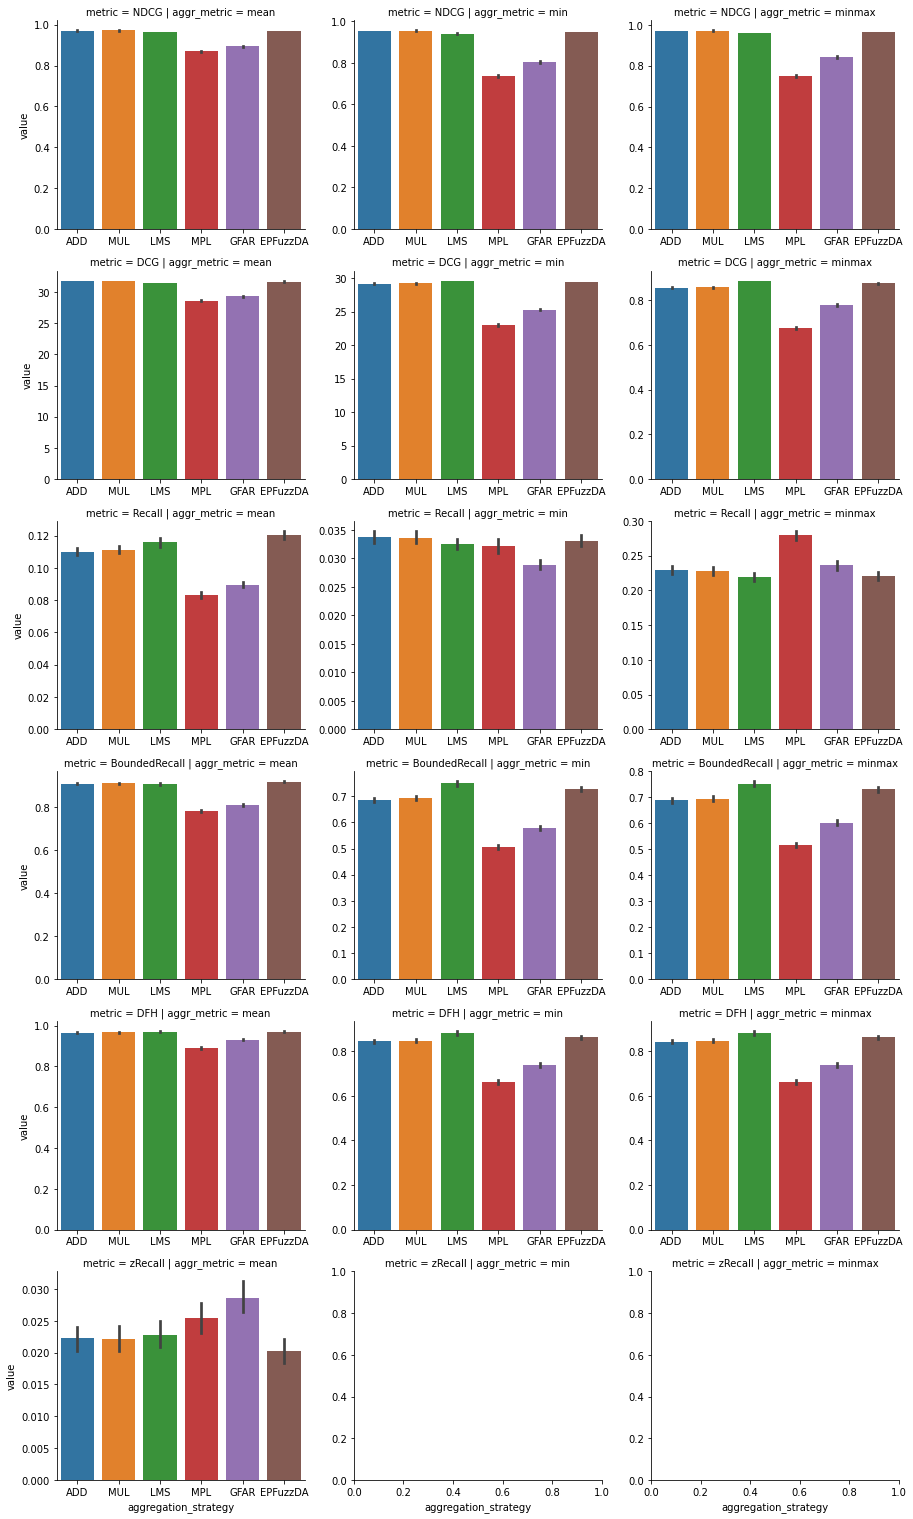

In [12]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

In [10]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

,group_size,group_similarity,group_members,metric,aggr_metric,value,aggregation_strategy,current_fold
0,2,random,"[4805, 5428]",NDCG,mean,0.021379,ADD,0
0,2,random,"[4805, 5428]",NDCG,min,0.000000,ADD,0
0,2,random,"[4805, 5428]",NDCG,minmax,0.000000,ADD,0
0,2,random,"[4805, 5428]",DCG,mean,0.150515,ADD,0
0,2,random,"[4805, 5428]",DCG,min,0.000000,ADD,0


### Metric variance per group size; keeping the aggregation strategies visible

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


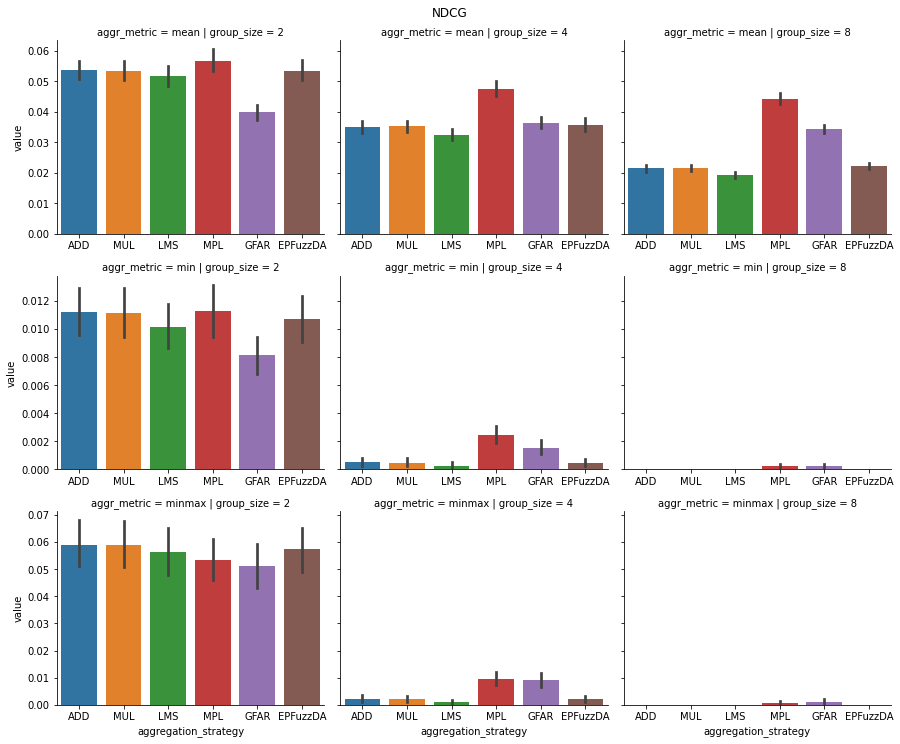

In [11]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.tight_layout()


### Metric variance per group size; merging all aggregation strategies

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


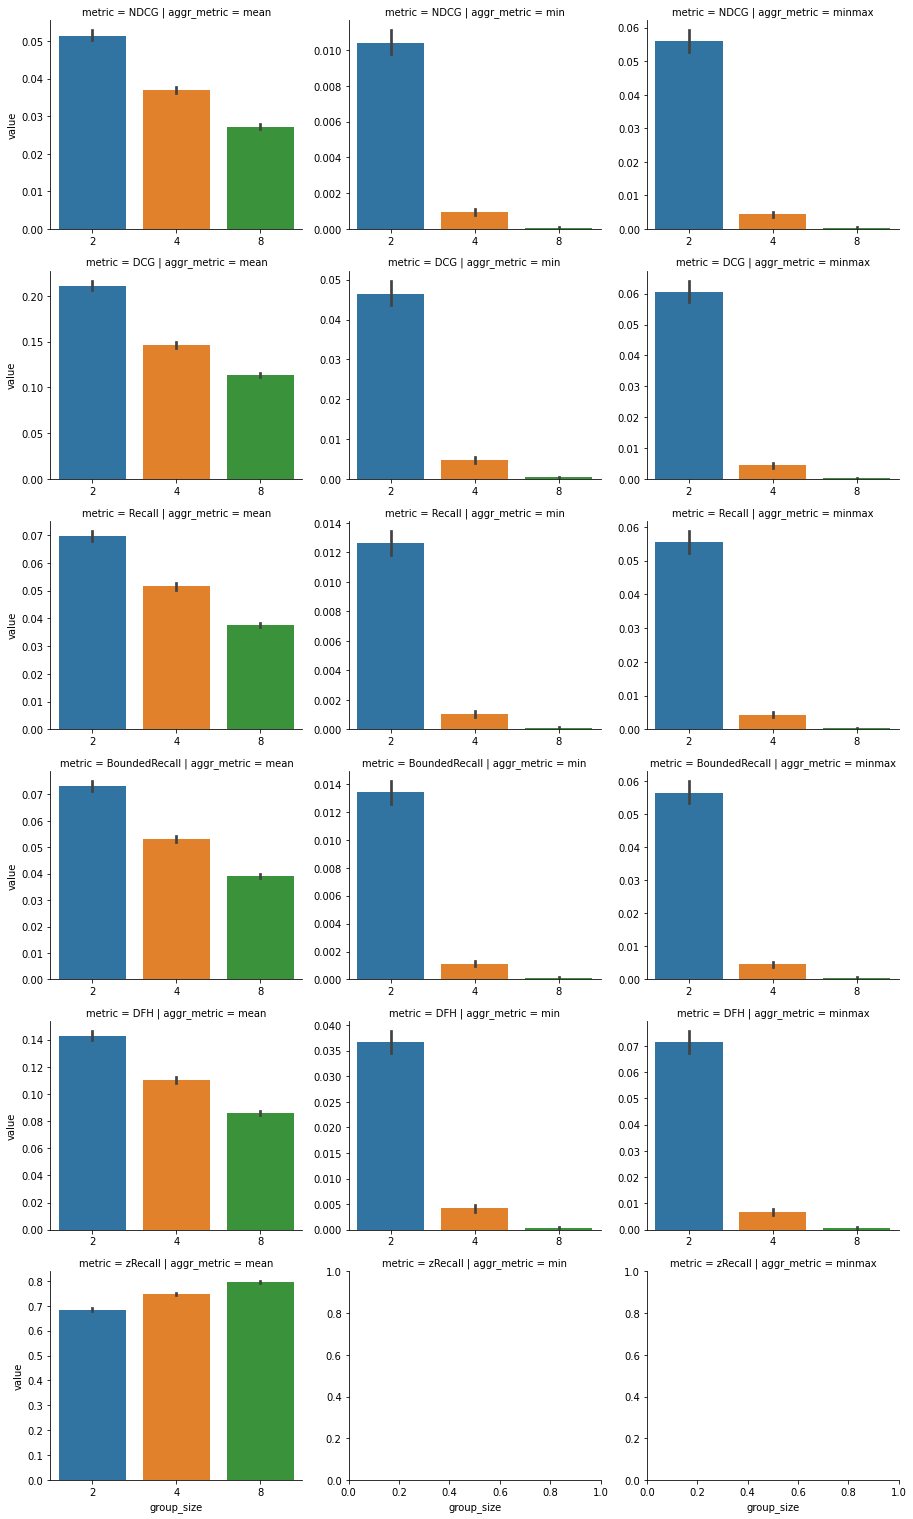

In [12]:
g = sns.catplot(data=eval_df_with_group_info, row="metric", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


### Metric variance per group size and group type; merging all aggregation strategies

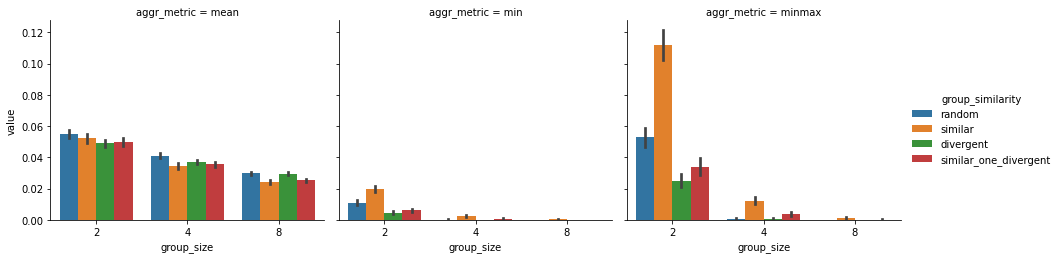

In [13]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], hue="group_similarity", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)

### Depict distribution of per-group values for all metrics

C:\Users\lpeska\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


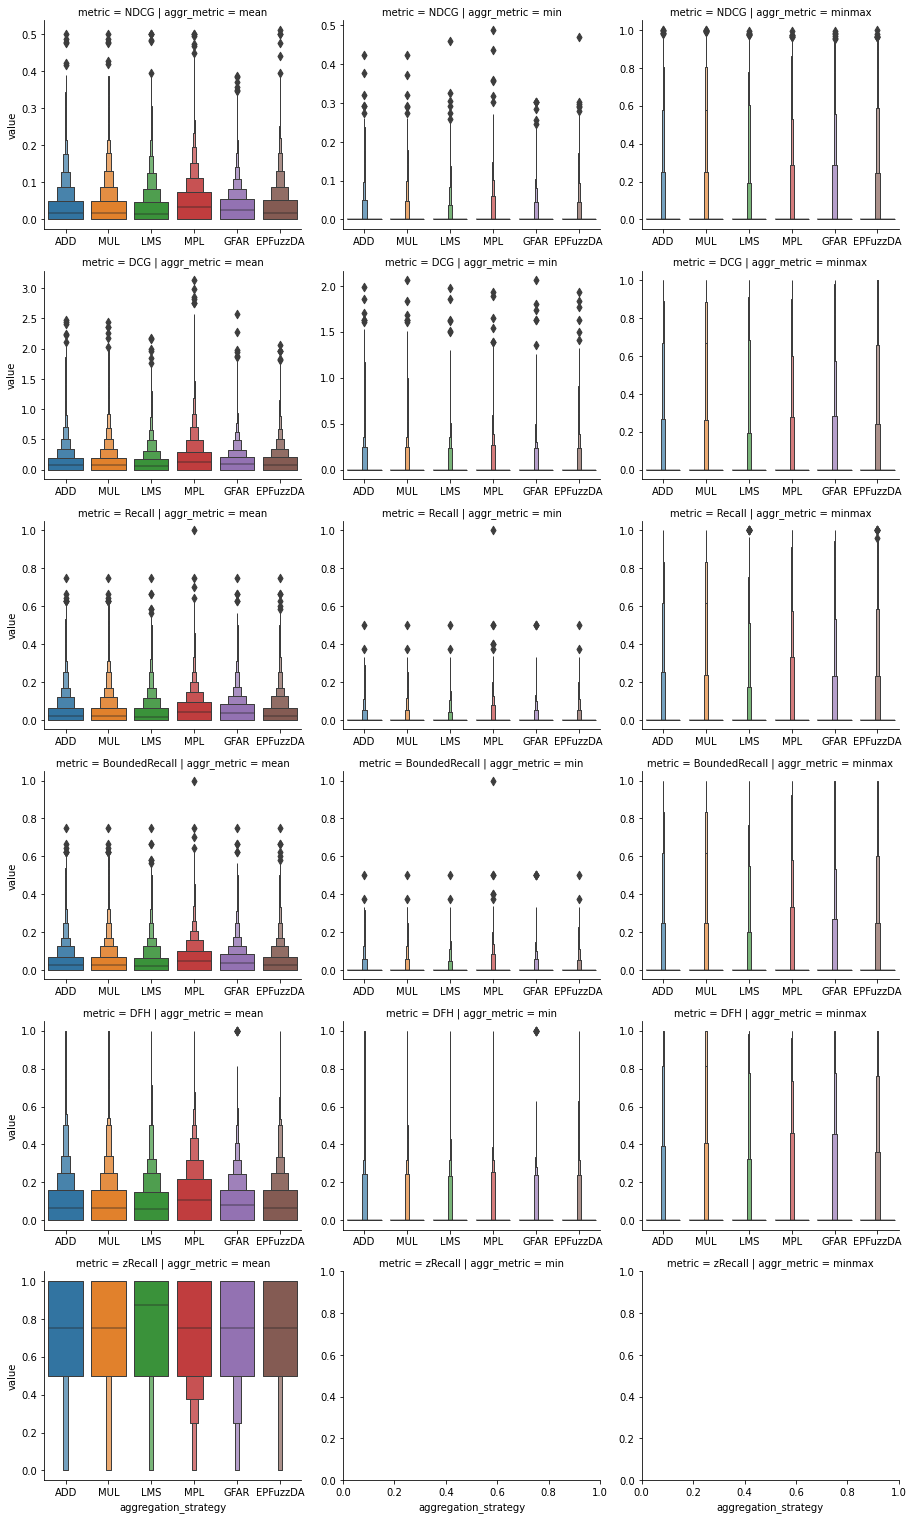

In [14]:
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [18]:
#group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()
#display(group_folds['value'].reset_index().sort_values(by='group_id'))

In [19]:
#eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

# Compare results of multiple evaluation runs
### Collect all results and extend eval_df with relevant evaluation parameters

In [21]:
#get all evaluation runs specified in valid_rows
def get_valid_evaluation_data(valid_rows):
    eval_df_list = []
    for res in valid_rows:
        path_to_eval_folder = preprocessed_dataset_folder + "/" + res
        eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))    
        for c in parameters_df_relevant.columns:
            eval_df[c]=parameters_df_relevant.loc[res,c]
        eval_df_list.append(eval_df)

    eval_df_concat = pd.concat(eval_df_list)
    return eval_df_concat

In [26]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[:4]
parameters_df_relevant.loc[valid_rows]

,evaluation_strategy,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback,binarize_feedback_positive_threshold,feedback_polarity_debiasing
eval_1663280669.8002677,COUPLED,False,0.0,True,5.0,2.0
eval_1663281533.6065123,COUPLED,False,0.0,True,4.0,2.0
eval_1663282398.1663923,COUPLED,False,0.0,True,3.0,2.0
eval_1663283262.6141398,COUPLED,False,0.0,True,2.0,2.0


In [27]:
eval_df_concat = get_valid_evaluation_data(valid_rows)
eval_df_concat.head(3)

,metric,aggr_metric,value,aggregation_strategy,group_id,current_fold,evaluation_strategy,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback,binarize_feedback_positive_threshold,feedback_polarity_debiasing
0,NDCG,mean,0.021379,ADD,0,0,COUPLED,False,0.0,True,5.0,2.0
1,NDCG,min,0.000000,ADD,0,0,COUPLED,False,0.0,True,5.0,2.0
2,NDCG,minmax,0.000000,ADD,0,0,COUPLED,False,0.0,True,5.0,2.0


### Coupled evaluation: effect of feedback binarization and inverse propensity debiasing

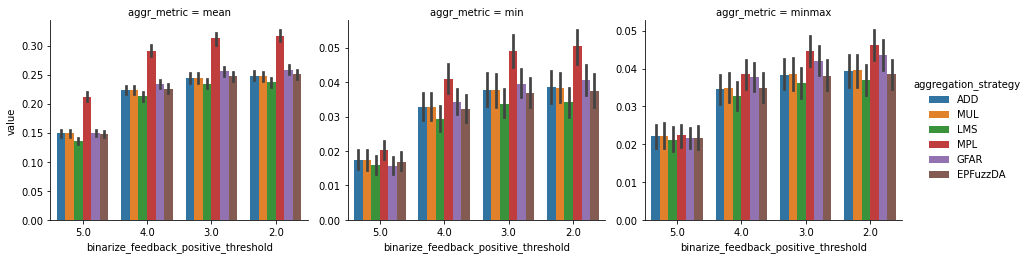

In [28]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex="col", sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

In [34]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[[1,4,5,6,7]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

,evaluation_strategy,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback,binarize_feedback_positive_threshold,feedback_polarity_debiasing
eval_1663281533.6065123,COUPLED,False,0.0,True,4.0,2.0
eval_1663284373.157593,COUPLED,True,0.1,True,4.0,2.0
eval_1663285470.9824817,COUPLED,True,0.5,True,4.0,2.0
eval_1663286563.1802847,COUPLED,True,1.0,True,4.0,2.0
eval_1663287655.3001313,COUPLED,True,2.0,True,4.0,2.0


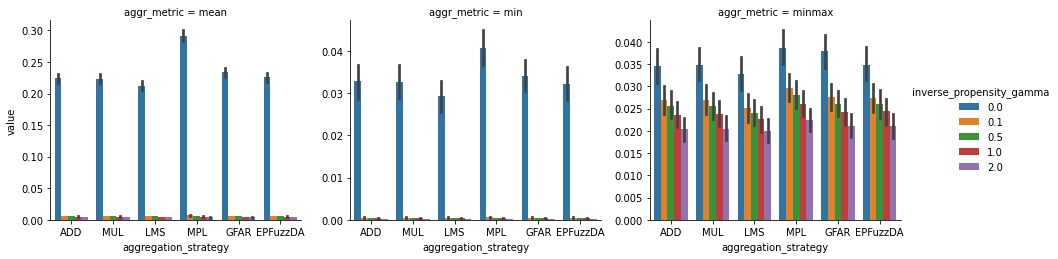

In [35]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="inverse_propensity_gamma", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

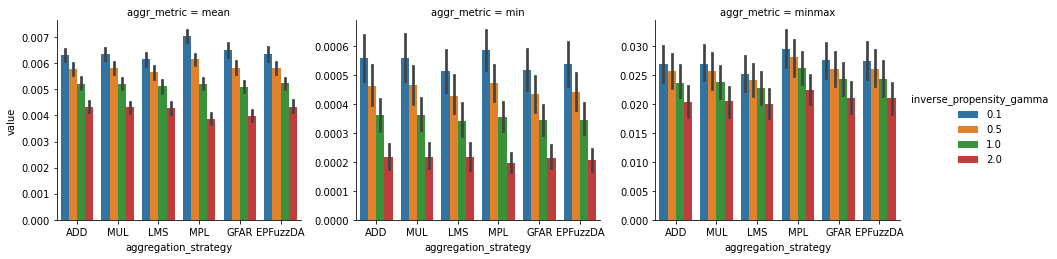

In [37]:
valid_rows = parameters_df_relevant.index[[4,5,6,7]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="inverse_propensity_gamma", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

### Decoupled evaluation: effect of polarity debiasing

In [39]:
valid_rows = parameters_df_relevant.index[11:15]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

,evaluation_strategy,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback,binarize_feedback_positive_threshold,feedback_polarity_debiasing
eval_1663298606.152506,DECOUPLED,True,0.5,False,4.0,0.0
eval_1663303136.2728064,DECOUPLED,True,0.5,False,4.0,-2.0
eval_1663307731.5719433,DECOUPLED,True,0.5,False,4.0,-4.0
eval_1663436168.0032027,DECOUPLED,True,0.5,False,4.0,-5.0


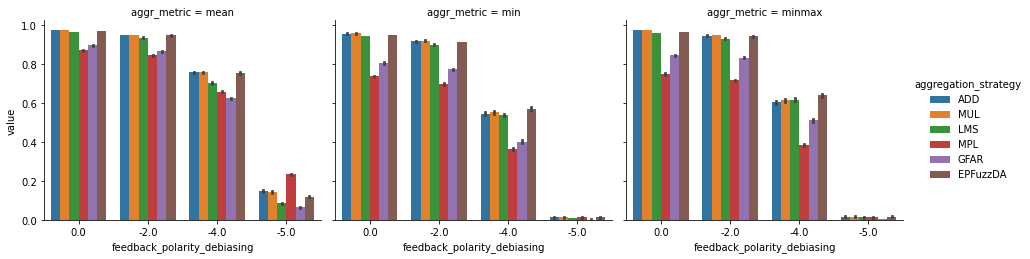

In [40]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="feedback_polarity_debiasing", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey="row",
                kind="bar",  height=3.5, aspect=1.2)

In [44]:
valid_rows = parameters_df_relevant.index[[10,15,16]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

,evaluation_strategy,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback,binarize_feedback_positive_threshold,feedback_polarity_debiasing
eval_1663294119.2699444,DECOUPLED,True,0.5,True,4.0,0.0
eval_1663441335.4183762,DECOUPLED,True,0.5,True,3.0,0.0
eval_1663446476.9394755,DECOUPLED,True,0.5,True,5.0,0.0


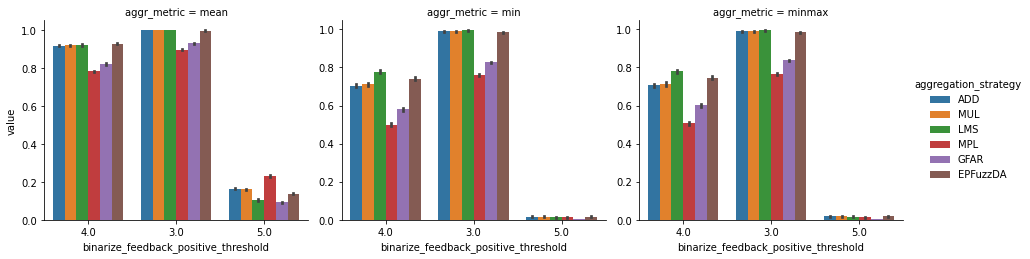

In [45]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)